In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from glob import glob
import os
from tqdm import tqdm

In [ ]:
def splitData(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nsamples) input feature vectors
        t: (np array of len Nsamples) targets; one hot vectors
        testFraction: (float) Nsamples_test = testFraction * Nsamples
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """
    if randomize is False:
      tot_samples = np.random.RandomState(seed=42).permutation(len(X))
    else:
      tot_samples = np.random.permutation(len(X))

    X_train = []
    X_test = []
    t_train = []
    t_test = []
    
    test_samples = max(1,int(len(X)*testFraction))
    # print(tot_samples[:test_samples])
    # print(tot_samples[test_samples:])

    for i in range(test_samples):
      X_test.append(X[tot_samples[i]])
      t_test.append(t[tot_samples[i]])

    for i in range(test_samples,len(X)):
      X_train.append(X[tot_samples[i]])
      t_train.append(t[tot_samples[i]])
    
    return np.asarray(X_train), np.asarray(t_train), np.asarray(X_test), np.asarray(t_test)

def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann'))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

def audio2spec(x, norm=True):
    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        x: np array of shape (Nsamples,)
    Output:
        X: (np array) spectrogram sequence
    '''
    X=[]
    for sample in x:
      X.append(calc_spec(sample))
    if norm is True:
      X = (X-np.mean(X))/np.std(X)
    return np.asarray(X)

In [ ]:
# PARAMETER FOR STFT
SAMPLING_RATE=16000
DURATION=10
N_FFT = 1024
WIN_LENGTH = 1024
HOP_LENGTH = 512

In [ ]:
# LOADING THE TRAINING SPECTROGRAMS
X = np.load('/content/drive/MyDrive/Sem 5/EE603/project/val_set/Final_Dataset/training_spectrogram.npy')
print(X.shape)
y = np.load('/content/drive/MyDrive/Sem 5/EE603/project/val_set/Final_Dataset/training_labels.npy')
print(y.shape)
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

(717, 513, 313)
(717,)


In [ ]:
# EXTRACTING THE MFCC FEATURES FROM THE SPECTROGRAM
def get_mfcc(X):
  X_new = []
  for i in range(len(X)):
    mel_spectrogram = librosa.feature.melspectrogram(S=X[i], n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc = librosa.feature.mfcc(S=mel_spectrogram, sr=16000,n_mfcc=20)
    mean = np.average(mfcc)
    std = np.std(mfcc)
    if(std == 0):
      std = std + 1e-25
    mfcc = (mfcc - mean)/std
    X_new.append(mfcc)
  return np.array(X_new)
X = get_mfcc(X)

In [ ]:
# FUNCTIONS TO CONVERT STRING TO ONE-HOT-VECTORS
def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])

def string2ohv(y):
  y_ohv = []
  for i in y:
    y_ohv.append(one_hot_enc(i))
  return np.array(y_ohv)

In [ ]:
X_train, y_train, X_test, y_test = splitData(X=X, t=y, testFraction=0.2, randomize=True)
print(X_train.shape)
print(X_test.shape)

(574, 20, 313)
(143, 20, 313)


In [ ]:
# RESHAPING THE DATA
def reshape(X, y):
  # Reshape the data to make each entry in the spectrogram a training sample
  X_new = []
  y_new = []
  for i in range(len(X)):
    X_new.append(np.transpose(X[i]))
    # print(X[i].shape[1])
    y_new.append([y[i]]*X[i].shape[1])
    # print(np.shape(y_new))
  X_new = np.array(X_new)
  y_new = np.array(y_new)
  X_new = X_new.reshape((-1, X[0].shape[0]))
  y_new = y_new.reshape((-1, 1))
  print(X_new.shape)
  print(y_new.shape)
  return X_new, y_new
X_train, y_train = reshape(X_train, y_train)
X_test, y_test = reshape(X_test, y_test)
y_test = string2ohv(y_test)
y_train = string2ohv(y_train)
print(y_train.shape)
print(y_test.shape)

(179662, 20)
(179662, 1)
(44759, 20)
(44759, 1)
(179662, 3)
(44759, 3)


In [ ]:
# PREPARING THE BAG OF FRAMES TO ESTABLISH TEMPORAL DEPENDENCE
def make_bags(X_prev):
  X_new = []
  X_new.append(X_prev[:7])
  X_new.append(X_prev[:7])
  X_new.append(X_prev[:7])

  for i in tqdm(range(len(X_prev)-6)):
    A = X_prev[i:i+7]
    X_new.append(A)

  X_new.append(X_prev[-7:])
  X_new.append(X_prev[-7:])
  X_new.append(X_prev[-7:])
  
  X_new = np.array(X_new)
  return X_new
X_test_reshaped = make_bags(X_test)
print(X_test_reshaped.shape)
X_train_reshaped = make_bags(X_train)
print(X_train_reshaped.shape)

100%|██████████| 44753/44753 [00:00<00:00, 1135358.51it/s]


(44759, 7, 20, 1)


100%|██████████| 179656/179656 [00:00<00:00, 1150312.68it/s]


(179662, 7, 20, 1)


In [ ]:
class Classifier: 
    '''
    Create a linear classifier to classify each frame
    '''
    def __init__(self,lr=10**-2,epoch=10**4):
        self.W = -1
        self.b = 0
        self.lr = lr
        self.epoch = epoch

    def softMax(self,z):
      z = np.exp(z - np.max(z))
      return z/np.sum(z)

    def train(self,x_train, y_train, x_test=None, y_test=None):
        '''
        Train the linear classifier
        Inputs:
            x_train: training set
            y_train: training labels
        Output:
            None
        '''
        print("Received input data and labels of shapes:",np.shape(x_train), np.shape(y_train))
        n_files = np.shape(x_train)[0]
        n_features = np.shape(x_train)[1]
        n_frames = np.shape(x_train)[2]
        n_classes = np.shape(y_train)[1]
        m = n_files
        m_test = np.shape(x_test)[0]

        print(n_files, "n_files")
        print(n_frames, "n_frames")
        print(n_features, "n_features")
        print(n_classes, "n_classes")

        self.W = np.random.RandomState(seed=42).random((n_features, n_classes))
        self.b = np.random.RandomState(seed=42).random(n_classes)
        print("Initialised weights and bias with shapes:", np.shape(self.W), np.shape(self.b))

        X = []
        Y = []
        X_t = []
        Y_t = []
        losses = []

        for i in range(n_files):
          for j in range(n_frames):
            X.append(x_train[i][:,j])
            Y.append(y_train[i])

        for i in range(m_test):
          for j in range(n_frames):
            X_t.append(x_test[i][:,j])
            Y_t.append(y_test[i])

        X = np.asarray(X)
        Y = np.asarray(Y)
        X_t = np.asarray(X_t)
        Y_t = np.asarray(Y_t)
        print("final shapes of data fed to training:",np.shape(X),np.shape(Y))
        print("final shapes of data fed to validation:",np.shape(X_t),np.shape(Y_t))

        for i in tqdm(range(self.epoch)):
            Z = X@self.W + self.b
            Y_hat = self.softMax(Z)

            Y_hat_t = self.softMax(X_t@self.W + self.b)

            w_grad = (1/m)*np.dot(X.T, (Y_hat - Y)) 
            b_grad = (1/m)*np.sum(Y_hat - Y)
            
            self.W -= self.lr*w_grad
            self.b -= self.lr*b_grad
            
            # loss = (-1/m)*np.sum(np.log(Y_hat+1e-9)*Y )
            loss_train = -np.mean(np.log(1e-10+Y_hat[np.arange(len(Y)), np.argmax(Y, axis=1)]))
            loss_val = -np.mean(np.log(1e-10+Y_hat_t[np.arange(len(Y_t)), np.argmax(Y_t, axis=1)]))
            losses.append((loss_train,loss_val))
        return losses       

    def save_model(self, save_path):
        '''
        Save the trained model on local disk
        Input:
            save_path: location at which model is to be saved
        Output:
            None
        '''
        
        with open(os.path.join(save_path,'W.npy'), 'wb') as f:
          np.save(f,self.W)
        with open(os.path.join(save_path,'b.npy'), 'wb') as f:
          np.save(f,self.b)
    
    def load_model(self, load_path):
        '''
        Save the trained model on local disk
        Input:
            load_path: location from which model is to be loaded
        Output:
            None
        '''

        with open(os.path.join(load_path,'W.npy'), 'rb') as f:
          self.W = np.load(f)
        with open(os.path.join(load_path,'b.npy'), 'rb') as f:
          self.b = np.load(f)
    
    def predict_framewise(self,x_test):
        '''
        Framewise classification (speech or music)
        Input:
            x_test: single frame (n_features,1)
        Output:
            y_pred_framewise = class prediction
        '''
        z = x_test@self.W + self.b
        y_hat = np.argmax(self.softMax(z))
        y_hot = np.zeros(np.shape(z)[0])
        y_hot[y_hat] = 1
        return y_hot

    def predict_aggregate(self,y_pred_framewise):
        '''
        Aggregate frames to give a single class label (music or speech) to the entire audio file
        Input:
            y_pred_framewise: framewise prediction
        Output:
            y_hat: frame aggregate (one-hot vectors)
        '''
        y_pred_framewise = np.asarray(y_pred_framewise)
        if y_pred_framewise.ndim > 1:
          counts = np.sum(y_pred_framewise, axis=0)
        y_hat = np.argmax(counts)
        y_hot = np.zeros(np.shape(counts)[0])
        y_hot[y_hat] = 1
        return y_hot

    def predict(self,x_test):
      '''
      Return one hot encoded classification results for the test set
      Input: 
        x_test: testing set (normalised spectrograms)
      Output:
        y_hat: list of one hot vectors for classification on x_test
      '''
      y_hat = []
      for f in x_test:
        y_pred_framewise = []
        for window in range(np.shape(f)[1]):
          y_pred_framewise.append(self.predict_framewise(f[:,window]))
        y_hat.append(self.predict_aggregate(y_pred_framewise))
      return y_hat

In [ ]:
EPOCHS = 5*10**2
LR = 10**-2
X_train = np.reshape(X_train_reshaped, (np.shape(X_train_reshaped)[0],-1,1))
X_test = np.reshape(X_test_reshaped, (np.shape(X_test_reshaped)[0],-1,1))

print(np.shape(X_train), np.shape(X_test))

(179662, 140, 1) (44759, 140, 1)


In [ ]:
model = Classifier(lr=LR,epoch=EPOCHS) 
hist=model.train(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test) 

Received input data and labels of shapes: (179662, 140, 1) (179662, 3)
179662 n_files
1 n_frames
140 n_features
3 n_classes
Initialised weights and bias with shapes: (140, 3) (3,)
final shapes of data fed to training: (179662, 140) (179662, 3)
final shapes of data fed to validation: (44759, 140) (44759, 3)


100%|██████████| 500/500 [14:27<00:00,  1.73s/it]


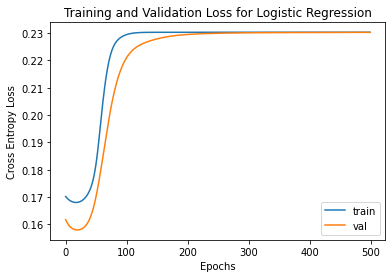

In [ ]:
plt.title("Training and Validation Loss for Logistic Regression")
# plt.plot(np.arange(EPOCHS),[x[0]*500/X_test.shape[0] for x in hist], label='train')
# plt.plot(np.arange(EPOCHS),[x[1]*500/X_test.shape[0] for x in hist], label='val')
plt.plot(np.arange(EPOCHS),[x[0]/100 for x in hist], label='train')
plt.plot(np.arange(EPOCHS),[x[1]/100 for x in hist], label='val')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

In [ ]:
y_hat = model.predict(x_test=X_test)

In [ ]:
test_accuracy = np.mean(np.asarray(y_hat).ravel() == np.asarray(y_test).ravel()) * 100
# test_accuracy = classifier.score(X_test, y_test)
print('Test accuracy:', test_accuracy)

Test accuracy: 54.312354312354316


In [ ]:
import sklearn
print(sklearn.metrics.f1_score(y_hat, y_test, average='micro'))

0.3146853146853147


In [ ]:
%cd /content/drive/MyDrive/Sem 5/EE603/project

/content/drive/MyDrive/Sem 5/EE603/project


In [ ]:
model.save_model('')
!ls

model.load_model('')
print(model.W)
print(model.b)
print(np.shape(model.W))
print(np.shape(model.b))

 b.npy				  dcase.ipynb	      mocktest_set      W.npy
 ClassifierOldMFCCVariant.ipynb   GMM.ipynb	      OldLogReg.ipynb
'Copy of GMM.ipynb'		  LogReg.ipynb	      val_set
'Copy of LogReg.ipynb'		 'MLSP AED.gslides'   val_set_old
[[-6.68810451 -6.00342399 -6.44242718]
 [ 2.34775433  2.13447564  0.54360827]
 [ 0.33382305  1.04198339  0.97845316]
 [ 1.20529702  0.65267836  1.34873621]
 [ 1.03494185  0.38919057  0.55863671]
 [ 0.3900736   0.63841936  0.90220398]
 [ 0.63352111  0.47332005  0.98877598]
 [ 0.38734372  0.57905984  0.74372678]
 [ 0.66033439  1.00736073  0.57680382]
 [ 0.7987278   0.91042441  0.42380548]
 [ 0.88118636  0.41512454  0.44213435]
 [ 1.25739207  1.30199454  1.18551586]
 [ 0.58794193  0.34027323  1.06102431]
 [ 0.80365     0.41929217  0.87266849]
 [ 0.30525755  1.13234676  0.63613373]
 [ 1.02780747  0.59919522  0.89705994]
 [ 0.85875482  0.4215938   1.34579509]
 [ 1.10366951  1.19563462  1.2715532 ]
 [ 0.93546982  1.17563328  0.46601001]
 [ 0.54457585  0.31421843  0.70

In [ ]:
!ls

 b.npy				  dcase.ipynb	      mocktest_set      W.npy
 ClassifierOldMFCCVariant.ipynb   GMM.ipynb	      OldLogReg.ipynb
'Copy of GMM.ipynb'		  LogReg.ipynb	      val_set
'Copy of LogReg.ipynb'		 'MLSP AED.gslides'   val_set_old
